In [ ]:
import os
import random
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.optim as optim
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, roc_curve, auc)
from sklearn.preprocessing import label_binarize

In [ ]:
!pip install timm

In [ ]:
try:
    import timm
    TIMM_AVAILABLE = True
except Exception:
    TIMM_AVAILABLE = False

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cuda


In [ ]:
DATA_DIR = "/content/drive/MyDrive/dataset"

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_CLASSES = 2
LR = 1e-4
NUM_EPOCHS = 20
WEIGHT_DECAY = 1e-4
SAVE_DIR = "./models"
os.makedirs(SAVE_DIR, exist_ok=True)

In [ ]:
class SDNETDataset(Dataset):
    def __init__(self, root, transform=None):
        super().__init__()
        self.root = Path(root)
        self.transform = transform
        classes = sorted([d.name for d in self.root.iterdir() if d.is_dir()])
        self.class_to_idx = {c:i for i,c in enumerate(classes)}
        self.samples = []
        for cls in classes:
            for img_path in (self.root/cls).glob("*"):
                self.samples.append((str(img_path), self.class_to_idx[cls]))
        if len(self.samples) == 0:
            raise RuntimeError(f"No images found in {root}. Check path and folder layout.")
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        p, y = self.samples[idx]
        img = Image.open(p).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, y

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

In [ ]:
test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

In [ ]:
train_ds = SDNETDataset(os.path.join(DATA_DIR, "train"), transform=train_transforms)
val_ds   = SDNETDataset(os.path.join(DATA_DIR, "val"),   transform=test_transforms)
test_ds  = SDNETDataset(os.path.join(DATA_DIR, "test"),  transform=test_transforms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
print("Train size:", len(train_ds), "Val:", len(val_ds), "Test:", len(test_ds))

Train size: 44874 Val: 5609 Test: 5609


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
def get_resnet50(num_classes=2, pretrained=True):
    model = models.resnet50(pretrained=pretrained)
    nfeats = model.fc.in_features
    model.fc = nn.Linear(nfeats, num_classes)
    return model

In [ ]:
def get_efficientnet_b0(num_classes=2, pretrained=True):
    try:
        model = models.efficientnet_b0(pretrained=pretrained)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    except Exception as e:
        if TIMM_AVAILABLE:
            model = timm.create_model("efficientnet_b0", pretrained=pretrained, num_classes=num_classes)
        else:
            raise e
    return model

In [ ]:
def get_vit_b16(num_classes=2, pretrained=True):
    try:
        model = models.vit_b_16(pretrained=pretrained)
        model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
    except Exception:
        if TIMM_AVAILABLE:
            model = timm.create_model("vit_base_patch16_224", pretrained=pretrained, num_classes=num_classes)
        else:
            raise RuntimeError("ViT not available: install timm or update torchvision")
    return model

In [ ]:
class CNN_LSTM(nn.Module):
    def __init__(self, patch_size=56, hidden_dim=128, rnn_type='lstm', num_classes=2):
        super().__init__()
        self.patch_size = patch_size
        self.cnn_patch = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten()
        )
        self.feature_dim = 64
        if rnn_type.lower() == 'lstm':
            self.rnn = nn.LSTM(self.feature_dim, hidden_dim, batch_first=True, bidirectional=True)
        else:
            self.rnn = nn.GRU(self.feature_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim*2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):

        B, C, H, W = x.shape
        ps = self.patch_size

        patches = []
        for i in range(0, H, ps):
            for j in range(0, W, ps):
                patch = x[:, :, i:i+ps, j:j+ps]
                patches.append(patch)

        feats = []
        for p in patches:
            f = self.cnn_patch(p)
            feats.append(f.unsqueeze(1))
        seq = torch.cat(feats, dim=1)
        r_out, _ = self.rnn(seq)

        pooled = r_out.mean(dim=1)
        out = self.classifier(pooled)
        return out

In [ ]:
def prepare_model(name="resnet50", num_classes=2, pretrained=True, rnn_type='lstm'):
    if name == "baseline":
        m = SimpleCNN(num_classes=num_classes)
    elif name == "resnet50":
        m = get_resnet50(num_classes=num_classes, pretrained=pretrained)
    elif name == "efficientnet":
        m = get_efficientnet_b0(num_classes=num_classes, pretrained=pretrained)
    elif name == "vit":
        m = get_vit_b16(num_classes=num_classes, pretrained=pretrained)
    elif name == "cnn_lstm":
        m = CNN_LSTM(patch_size=IMG_SIZE//4, hidden_dim=128, rnn_type=rnn_type, num_classes=num_classes)
    else:
        raise ValueError(name)
    return m.to(DEVICE)

In [ ]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    losses = []
    preds = []
    targets = []
    for xb, yb in tqdm(loader, desc="Train batch"):
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        preds.extend(torch.argmax(logits.detach().cpu(), dim=1).numpy().tolist())
        targets.extend(yb.detach().cpu().numpy().tolist())
    return np.mean(losses), preds, targets


In [ ]:
@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    losses = []
    preds = []
    targets = []
    probs = []
    for xb, yb in tqdm(loader, desc="Eval batch"):
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        loss = criterion(logits, yb)
        losses.append(loss.item())
        prob = torch.softmax(logits, dim=1)[:,1].detach().cpu().numpy()
        p = torch.argmax(logits, dim=1).detach().cpu().numpy()
        preds.extend(p.tolist())
        probs.extend(prob.tolist())
        targets.extend(yb.detach().cpu().numpy().tolist())
    return np.mean(losses), preds, targets, probs

In [ ]:
def compute_metrics(y_true, y_pred, y_score=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc_auc = None
    if y_score is not None:
        try:
            roc_auc = roc_auc_score(y_true, y_score)
        except Exception:
            roc_auc = None
    return {"accuracy":acc, "precision":prec, "recall":rec, "f1":f1, "roc_auc":roc_auc}

In [ ]:
def run_training(model_name="resnet50", epochs=NUM_EPOCHS, lr=LR):
    print("Preparing model:", model_name)
    model = prepare_model(name=model_name, num_classes=NUM_CLASSES, pretrained=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)
    best_val_f1 = 0.0
    history = {"train_loss":[], "val_loss":[], "val_f1":[]}
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        train_loss, tr_preds, tr_targets = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_preds, val_targets, val_probs = evaluate(model, val_loader, criterion)
        metrics = compute_metrics(val_targets, val_preds, y_score=val_probs)
        print(f"Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f}")
        print("Val metrics:", metrics)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_f1"].append(metrics["f1"])

        if metrics["f1"] > best_val_f1:
            best_val_f1 = metrics["f1"]
            torch.save(model.state_dict(), os.path.join(SAVE_DIR, f"best_{model_name}.pth"))
    return model, history

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels=["noncrack","crack"]):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
def plot_roc(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1],[0,1],"--")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC curve")
    plt.legend()
    plt.show()

In [ ]:
def grad_cam(model, input_tensor, target_class=None, layer_name="layer4"):

    model.eval()
    input_tensor = input_tensor.to(DEVICE)

    activations = {}
    gradients = {}
    def save_activation(name):
        def hook(module, inp, out):
            activations[name] = out.detach()
        return hook
    def save_gradient(name):
        def hook(module, grad_in, grad_out):
            gradients[name] = grad_out[0].detach()
        return hook


    target_layer = dict(model.named_modules()).get(layer_name, None)
    if target_layer is None:
        raise RuntimeError(f"Layer {layer_name} not found in model")

    target_layer.register_forward_hook(save_activation(layer_name))
    target_layer.register_backward_hook(save_gradient(layer_name))

    logits = model(input_tensor)
    if target_class is None:
        target_class = logits.argmax(dim=1).item()
    loss = logits[0, target_class]
    model.zero_grad()
    loss.backward()

    act = activations[layer_name].squeeze(0)
    grad = gradients[layer_name].squeeze(0)
    weights = grad.mean(dim=(1,2))
    gcam = (weights.view(-1,1,1) * act).sum(dim=0).cpu().numpy()
    gcam = np.maximum(gcam, 0)
    gcam = (gcam - gcam.min()) / (gcam.max()-gcam.min() + 1e-8)

    import cv2
    gcam = cv2.resize(gcam, (input_tensor.shape[-1], input_tensor.shape[-2]))
    return gcam


In [ ]:
def show_cam_on_image(img_tensor, mask):

    img = img_tensor.cpu().numpy().transpose(1,2,0)
    mean = np.array([0.485,0.456,0.406]); std = np.array([0.229,0.224,0.225])
    img = std * img + mean
    img = np.clip(img, 0,1)
    heatmap = plt.get_cmap("jet")(mask)[:,:,:3]
    overlay = heatmap*0.4 + img*0.6
    plt.figure(figsize=(6,6))
    plt.imshow(overlay)
    plt.axis("off")
    plt.show()

Preparing model: resnet50


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 189MB/s]



Epoch 1/10


Eval batch: 100%|██████████| 176/176 [08:58<00:00,  3.06s/it]


Train loss: 0.2261 | Val loss: 0.5432
Val metrics: {'accuracy': 0.8283116420039223, 'precision': 0.9294436906377205, 'recall': 0.8632640201638311, 'f1': 0.8951323097027115, 'roc_auc': np.float64(0.7004528737818676)}

Epoch 2/10


Train batch:   0%|          | 0/1403 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Eval batch: 100%|██████████| 176/176 [00:30<00:00,  5.76it/s]


Train loss: 0.1904 | Val loss: 0.6046
Val metrics: {'accuracy': 0.7013727937243716, 'precision': 0.925303197353914, 'recall': 0.7051039697542533, 'f1': 0.800333770413637, 'roc_auc': np.float64(0.7184345686057709)}

Epoch 3/10


Train batch:   0%|          | 0/1403 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Eval batch: 100%|██████████| 176/176 [00:29<00:00,  6.01it/s]


Train loss: 0.1758 | Val loss: 0.6199
Val metrics: {'accuracy': 0.7145658762702799, 'precision': 0.9072164948453608, 'recall': 0.7393404746901912, 'f1': 0.8147205184585118, 'roc_auc': np.float64(0.6435427094355475)}

Epoch 4/10


Train batch:   0%|          | 0/1403 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Eval batch: 100%|██████████| 176/176 [00:29<00:00,  5.90it/s]


Train loss: 0.1680 | Val loss: 0.5942
Val metrics: {'accuracy': 0.7297200927081476, 'precision': 0.9402985074626866, 'recall': 0.7277882797731569, 'f1': 0.820506748756808, 'roc_auc': np.float64(0.7923455810377557)}

Epoch 5/10


Train batch:   0%|          | 0/1403 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Eval batch: 100%|██████████| 176/176 [00:30<00:00,  5.68it/s]


Train loss: 0.1621 | Val loss: 1.5872
Val metrics: {'accuracy': 0.3123551435193439, 'precision': 0.8062330623306233, 'recall': 0.2499474900231044, 'f1': 0.38159371492704824, 'roc_auc': np.float64(0.5836543377203932)}

Epoch 6/10


Train batch:   0%|          | 0/1403 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Eval batch: 100%|██████████| 176/176 [00:29<00:00,  5.89it/s]


Train loss: 0.1561 | Val loss: 2.4539
Val metrics: {'accuracy': 0.24763772508468532, 'precision': 0.7275021026072329, 'recall': 0.18168452005881117, 'f1': 0.2907563025210084, 'roc_auc': np.float64(0.48891841336646413)}

Epoch 7/10


Train batch:   0%|          | 0/1403 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Eval batch: 100%|██████████| 176/176 [00:31<00:00,  5.64it/s]


Train loss: 0.1503 | Val loss: 1.0740
Val metrics: {'accuracy': 0.5289712961312177, 'precision': 0.8842945230322815, 'recall': 0.5120772946859904, 'f1': 0.6485767491354083, 'roc_auc': np.float64(0.6408755989109629)}

Epoch 8/10


Train batch:   0%|          | 0/1403 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Eval batch: 100%|██████████| 176/176 [00:29<00:00,  6.01it/s]


Train loss: 0.1479 | Val loss: 0.4601
Val metrics: {'accuracy': 0.871278302727759, 'precision': 0.9176835573940021, 'recall': 0.9319470699432892, 'f1': 0.9247603167986661, 'roc_auc': np.float64(0.677587131885247)}

Epoch 9/10


Train batch:   0%|          | 0/1403 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Eval batch: 100%|██████████| 176/176 [00:30<00:00,  5.85it/s]


Train loss: 0.1420 | Val loss: 1.0208
Val metrics: {'accuracy': 0.446781957568194, 'precision': 0.8697591436217663, 'recall': 0.4095778197857593, 'f1': 0.5569041839211767, 'roc_auc': np.float64(0.6462335980628773)}

Epoch 10/10


Train batch:   0%|          | 0/1403 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Eval batch: 100%|██████████| 176/176 [00:29<00:00,  5.94it/s]


Train loss: 0.1404 | Val loss: 0.7154
Val metrics: {'accuracy': 0.6580495632019968, 'precision': 0.9224368499257058, 'recall': 0.6519638731358958, 'f1': 0.7639675116908689, 'roc_auc': np.float64(0.7379610970424003)}


Eval batch:   0%|          | 0/176 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Eval batch: 100%|██████████| 176/176 [09:01<00:00,  3.08s/it]


Test metrics: {'accuracy': 0.6288108397218756, 'precision': 0.9062784349408554, 'recall': 0.6275992438563327, 'f1': 0.7416232315711094, 'roc_auc': np.float64(0.6889034034391063)}


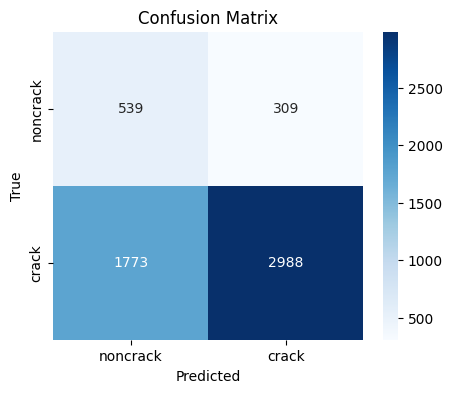

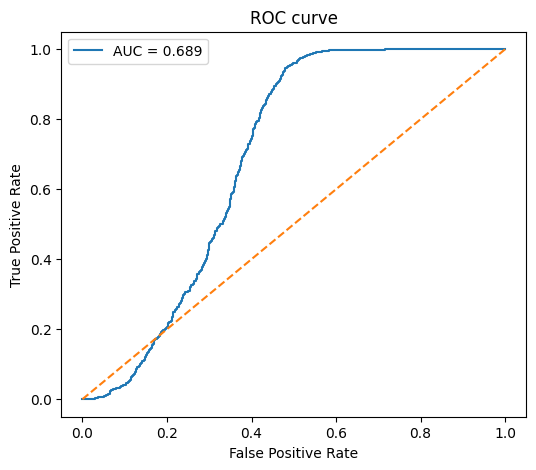

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


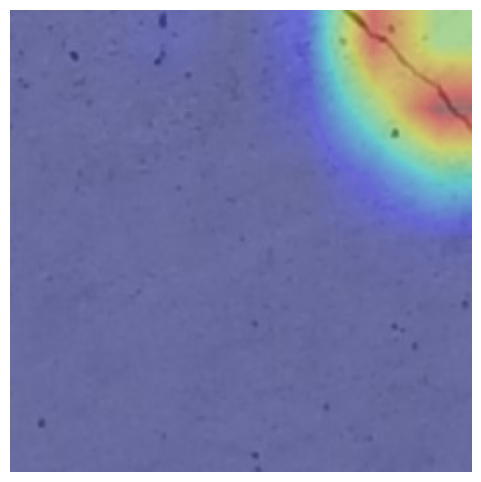

In [ ]:
if __name__ == "__main__":

    model_name = "resnet50"   # options: baseline, resnet50, efficientnet, vit, cnn_lstm
    model, history = run_training(model_name, epochs=10, lr=1e-4)


    criterion = nn.CrossEntropyLoss()
    test_loss, test_preds, test_targets, test_probs = evaluate(model, test_loader, criterion)
    metrics = compute_metrics(test_targets, test_preds, y_score=test_probs)
    print("Test metrics:", metrics)
    plot_confusion_matrix(test_targets, test_preds)
    if test_probs is not None:
        plot_roc(test_targets, test_probs)


    xb, yb = next(iter(test_loader))
    sample_img = xb[0:1]
    gcam = grad_cam(model, sample_img, layer_name="layer4")  # layer depends on model.
    show_cam_on_image(sample_img[0], gcam)